<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

## Exercise 3: In/out degree of inhbitory neurons
    
Because cortical inhibitory neuron's axons are relatively local they can be mostly contained with the mm scale dataset.  Therefore, after proofreading a large fraction of their output synaspes can be reconstructed.  Their dendrites are also contained within the volume and so their inputs are largely complete as well.  Therefore one simple question is whether the number of inputs a particular interneuron of a particular class is related to the number of outputs that cell sends locally.  

This exercise is to ask that question of the dataset, by finding the total number of synaptic inputs and outputs from individual inhibitory neurons in the dataset, and make scatter plots of the number of inputs and outputs broken down by cell type. 

</div>

In [1]:
mat_version = 1300

# Paths to compiled data for this workshop
syn_data_url = f"https://github.com/sdorkenw/MICrONS_workshop_CNC_forum/raw/refs/heads/main/data/synapses_proofread_V1_neurons_{mat_version}.feather"
cell_data_url = f"https://github.com/sdorkenw/MICrONS_workshop_CNC_forum/raw/refs/heads/main/data/cell_info_{mat_version}.feather" 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 3.1
Reference the data walkthrough, and copy over the local function  `filter_synapse_table` as it will be critical for this exercise.
    
</div>

In [3]:
def filter_synapse_table(synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None):   
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """
    
    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        pre_m = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_m = np.ones(len(synapse_table), dtype=bool)
        
    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        post_m = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_m = np.ones(len(synapse_table), dtype=bool)
        
    return synapse_table[pre_m & post_m]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 3.2
Load the <b>cell_df</b> and the <b>syn_df</b> dataframes. Using `filter_synapse_table`, filter the synapse table to only contain <b>ouputs from proofread inhibitory cells</b>.

Then do the same to find the <b>inputs to those same neurons</b> in the dataset. 

How many cells, total inputs and total outputs are there onto and from proofreading inhibitory cells?


    
</div>

In [4]:
# Load cell_df
cell_df = pd.read_feather(cell_data_url)

# Load syn_df
syn_df = pd.read_feather(syn_data_url)

# Get the proofread root ids of the inhibitory cells
proof_I_root_ids = np.array(cell_df[np.array(cell_df["proofreading_strategy"] != "") & np.array(cell_df["coarse_cell_type_auto"] == "I")]["pt_root_id"])

In [5]:
# Filter outputs of the inhibitory neurons
inh_neuron_out = filter_synapse_table(syn_df, pre_root_ids=proof_I_root_ids)

# Filter inputs to the inhibitory neurons
inh_neuron_in = filter_synapse_table(syn_df, post_root_ids=proof_I_root_ids)
print(len(proof_I_root_ids), len(inh_neuron_out), len(inh_neuron_in))

193 515176 1062246


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 3.3
Using group-bys and merges, construct a dataframe that contains a `pt_root_id`, 'cell_type_auto` it's total inputs, total outputs and cell type. 
    
Make a scatter plot of the number of inputs versus the number of outputs colored by cell type.  Do any cell types show a significant relationship? 
</div>

In [6]:
# Groupby 'pre_pt_root_id'
output_series = inh_neuron_out.groupby('pre_pt_root_id')['size'].count()
output_series.name = 'n_outputs'

# Groupby 'post_pt_root_id'
input_series = inh_neuron_in.groupby('post_pt_root_id')['size'].count()
input_series.name='n_inputs'

# Combine input and output series with cell type, on 'pt_root_id'
in_out_df = pd.DataFrame([output_series, input_series]).T
in_out_df=in_out_df.merge(cell_df[['pt_root_id', 'cell_type_auto']], left_index=True, right_on='pt_root_id')
in_out_df.head()

,n_outputs,n_inputs,pt_root_id,cell_type_auto
64047,42.0,15.0,864691134886037498,BC
24198,1833.0,3721.0,864691134918642954,MC
29561,1478.0,3405.0,864691134948652540,BC
84915,1893.0,7411.0,864691134965736479,BC
44644,2358.0,7064.0,864691134989909114,MC


<Axes: xlabel='n_outputs', ylabel='n_inputs'>

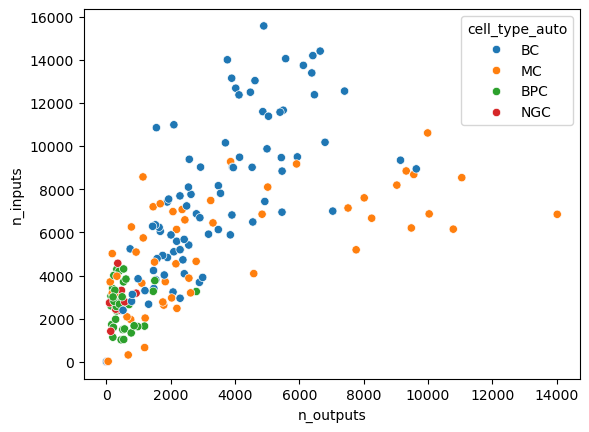

In [7]:
# Plot scatter of output v inputs. Tip: include cell type as 'hue'
f, ax = plt.subplots()
sns.scatterplot(x='n_outputs', y='n_inputs', hue='cell_type_auto',palette ='tab10', data = in_out_df)